In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from uncertainties import *

f = ["32", "10", "5", "3"]

V = []
time = []

for filename in f:
    df = pd.read_csv(f"{filename}.csv")
    V.append(df["volt(V)"].values)
    time.append(df['time(s)'].values)

def f1(t, V_0, tau, B):
    return V_0 * np.exp(- t / tau) + B    

# time = df["time(s)"].values
# V = df["volt(V)"].values
# time -= time[0]


# param, pcov = curve_fit(f1, time, V, p0=(15.1, 2*10**(-4), 0))
# (V_0_exp, tau_exp, B_exp) = (param[0], param[1], param[2])

# t = np.linspace(time[0], time[-1], 500)
# fit = f1(t, V_0_exp, tau_exp, B_exp)

# print(param)

# plt.plot(time, V, label="Potentiel condensateur")
# plt.plot(t, fit, label="fitting")
# plt.xlabel("Temps (s)")
# plt.ylabel("Potentiel (V)")
# plt.title(label="Décharge du condensateur à h=32mm")
# plt.show()

i:0 | V0: 15.010828411041762 ; 0.009022545596306374 | tau: 8.99463971530077e-05; 9.116667678931037e-08, B: 0.0047782214104151914 ; 0.0020712334001722742
i:1 | V0: 15.045928581066436 ; 0.01657512093619852 | tau: 0.00018359657477000856; 3.446005410834969e-07, B: 0.04509754368507175 ; 0.003939117684364467
i:2 | V0: 14.99718111739319 ; 0.004847580358511635 | tau: 0.0002579973328619086; 1.6158136223774972e-07, B: 0.08512887390945484 ; 0.0016552985035512891
i:3 | V0: 15.177598803690719 ; 0.003421286950426469 | tau: 0.00039855209455900314; 1.7908524716113755e-07, B: -0.07664504262860214 ; 0.0012514006977361557


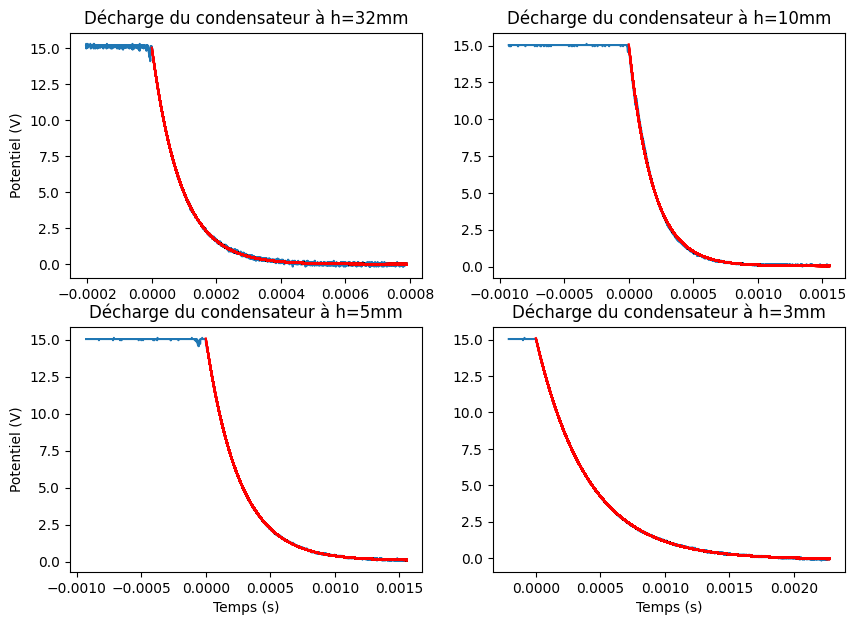

In [6]:
i32 = 510
i10 = 950
i5 = 923
i3 = 210

start_fit = [510, 930, 928, 210]
size = [32, 10, 5, 3]

fig, ax = plt.subplots(2, 2)
plt.rcParams['figure.figsize']=[10,7]

tau = []

for i in range(0, 4):
    start_index = start_fit[i]
    t = time[i]
    v = V[i]
    t -= t[start_index]


    param, pcov = curve_fit(f1, t[start_index:], v[start_index:], p0=(15.1, 2*10**(-4), 0), sigma = 0.1 * np.ones_like(t[start_index:]))
    (V_0_exp, tau_exp, B_exp) = (param[0], param[1], param[2])
    
    incer_exp = np.sqrt(np.diag(pcov))
    (v0_err, tau_err, B_err) = (incer_exp[0], incer_exp[1], incer_exp[2])

    print(f"i:{i} | V0: {V_0_exp} ; {v0_err} | tau: {tau_exp}; {tau_err}, B: {B_exp} ; {B_err}")
    tau.append(ufloat(tau_exp, tau_err))
    
    t_lin = np.linspace(t[start_index:], t[-1], 500)
    fit = f1(t_lin, V_0_exp, tau_exp, B_exp)

    ax[i // 2, i % 2].plot(t, v, label="Potentiel condensateur")
    ax[i // 2, i % 2].plot(t_lin, fit, label="Régression exponentielle", c="red")
    ax[i // 2, i % 2].set_xlabel("Temps (s)")
    ax[i // 2, i % 2].set_ylabel("Potentiel (V)")
    ax[i // 2, i % 2].set_title(label=f"Décharge du condensateur à h={size[i]}mm")
    
ax[1, 1].set_ylabel("")
ax[0, 1].set_ylabel("")
ax[0, 1].set_xlabel("")
ax[0, 0].set_xlabel("")

fig.savefig("decharge.eps", dpi=1000)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(8.99+/-0.18)e-11 vs (3.39+/-0.05)e-11
(1.84+/-0.04)e-10 vs (1.08+/-0.05)e-10
(2.58+/-0.05)e-10 vs (2.17+/-0.22)e-10
(3.99+/-0.08)e-10 vs (3.6+/-0.6)e-10
1.036255186403453e-09 8.80740905369559e-11 6.060239545304134e-11 8.741381590735978e-12
1.084124995696477e-09 4.553323595433588e-18 5.964918943052966e-19


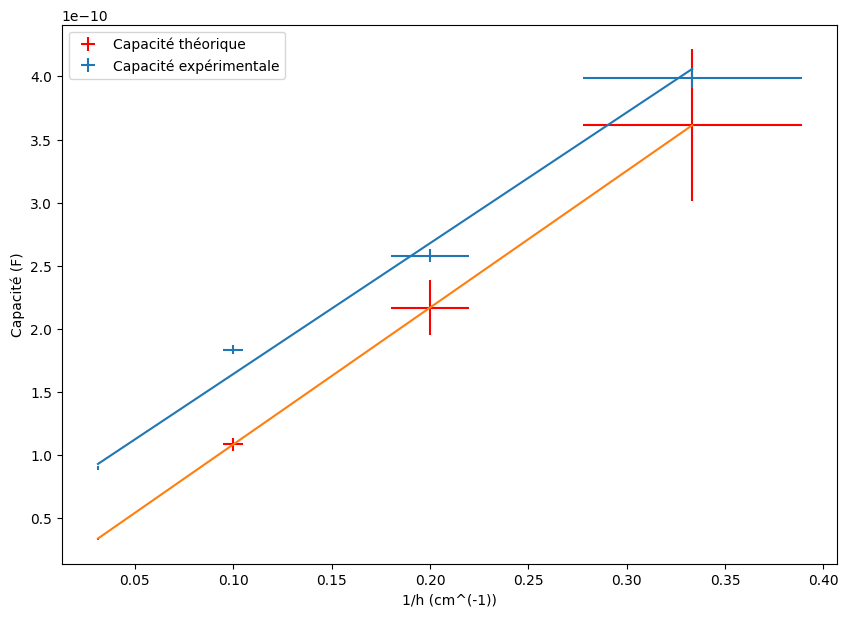

In [35]:
from uncertainties import unumpy

R = ufloat(1 * 10**6, 0.02 * 10**6)

C_exp = []
C_th = []

for t in tau:
    C_exp.append(t/R)
    
e0 = 8.85 * 10**(-12)
L = ufloat(350 * 10**(-3), 0.5*10**(-3))
S = L**2

for h in size:
    C_th.append(e0 * S / ufloat(h * 10**(-3), 0.5 * 10**(-3)))
    
for c_exp_1, c_th_2 in zip(C_exp, C_th):
    print(f"{c_exp_1} vs {c_th_2}")
    
capacity_val = []
capacity_err = []
capacity_th_val = []
capacity_th_err = []

for c_exp_1, c_th_2 in zip(C_exp, C_th):
    capacity_val.append(c_exp_1.nominal_value)
    capacity_err.append(c_exp_1.std_dev)
    capacity_th_val.append(c_th_2.nominal_value)
    capacity_th_err.append(c_th_2.std_dev)
    
size = np.array(size)
over_size = 1/size

def linear(x, a, b):
    return a * x + b

param1, pcov1 = curve_fit(linear, over_size, capacity_val, sigma = capacity_err)
(a1, b1) = (param1[0], param1[1])
incer1 = np.sqrt(np.diag(pcov1))
(a1_err, b1_err) = incer1

param2, pcov2 = curve_fit(linear, over_size, capacity_th_val, sigma = capacity_th_err)
(a2, b2) = (param2[0], param2[1])
incer2 = np.sqrt(np.diag(pcov2))
(a2_err, b2_err) = incer2

print(a1, a1_err, b1, b1_err)
print(a2, a2_err, b2_err)
    
plt.errorbar(x=1 / (size), y=capacity_th_val, xerr=0.5 * 1 / (size**2), yerr=capacity_th_err, fmt="None", c="red", label="Capacité théorique")
plt.errorbar(x=1 / (size), y=capacity_val, xerr=0.5 * 1 / (size**2), yerr=capacity_err, fmt="None", label="Capacité expérimentale")
plt.plot(over_size, linear(over_size, a1, b1))
plt.plot(over_size, linear(over_size, a2, b2))
plt.ylabel("Capacité (F)")
plt.xlabel("1/h (cm^(-1))")
plt.legend()
plt.savefig("C_over_h.eps", dpi=1000)